# Multi-task Learning for Predicting House Prices and House Category

## 1. Install Packages and Load Libraries

In [ ]:
#!pip install pytorch-lightning
#!pip install optuna
#!pip install optuna-integration
!pip install torchmetrics


In [150]:
import tensorflow as tf
from optuna.integration import PyTorchLightningPruningCallback
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.metrics import accuracy_score
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score, classification_report
import torchmetrics
from torchmetrics import Accuracy


## 2. Import tha dataset

In [9]:
# Import data
df = pd.read_csv("train.csv")

# Display basic information about the dataset
print(df.shape)
print(df.head())
print(df.describe())

# Check for missing values
print(df.isnull().sum())


(1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008  

## 3. Data Preprocessing

In [10]:
# Drop irrelevant column
df = df.drop('Id', axis=1)
df.head(3)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### 3.1. Visualize the distrubution of Salse Price

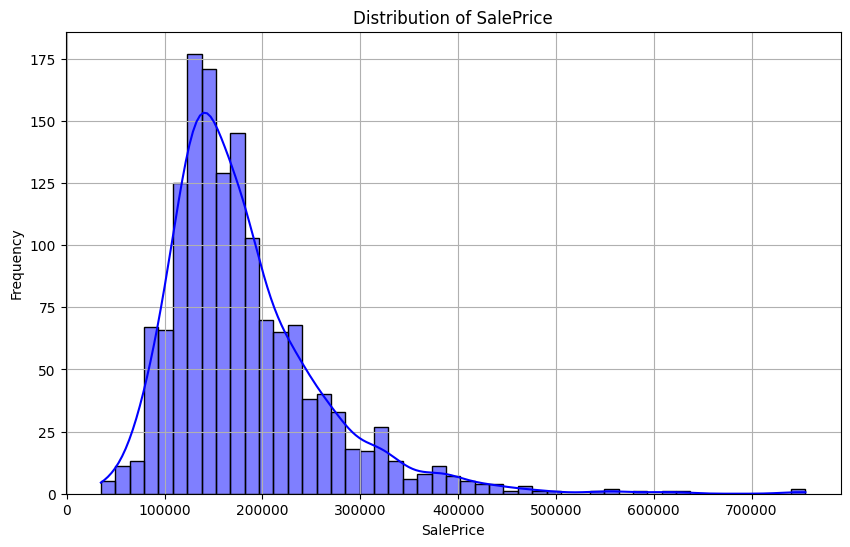

In [11]:
# Plot the distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], kde=True, color='blue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### 3.2. Visualize distribution of numeric columns

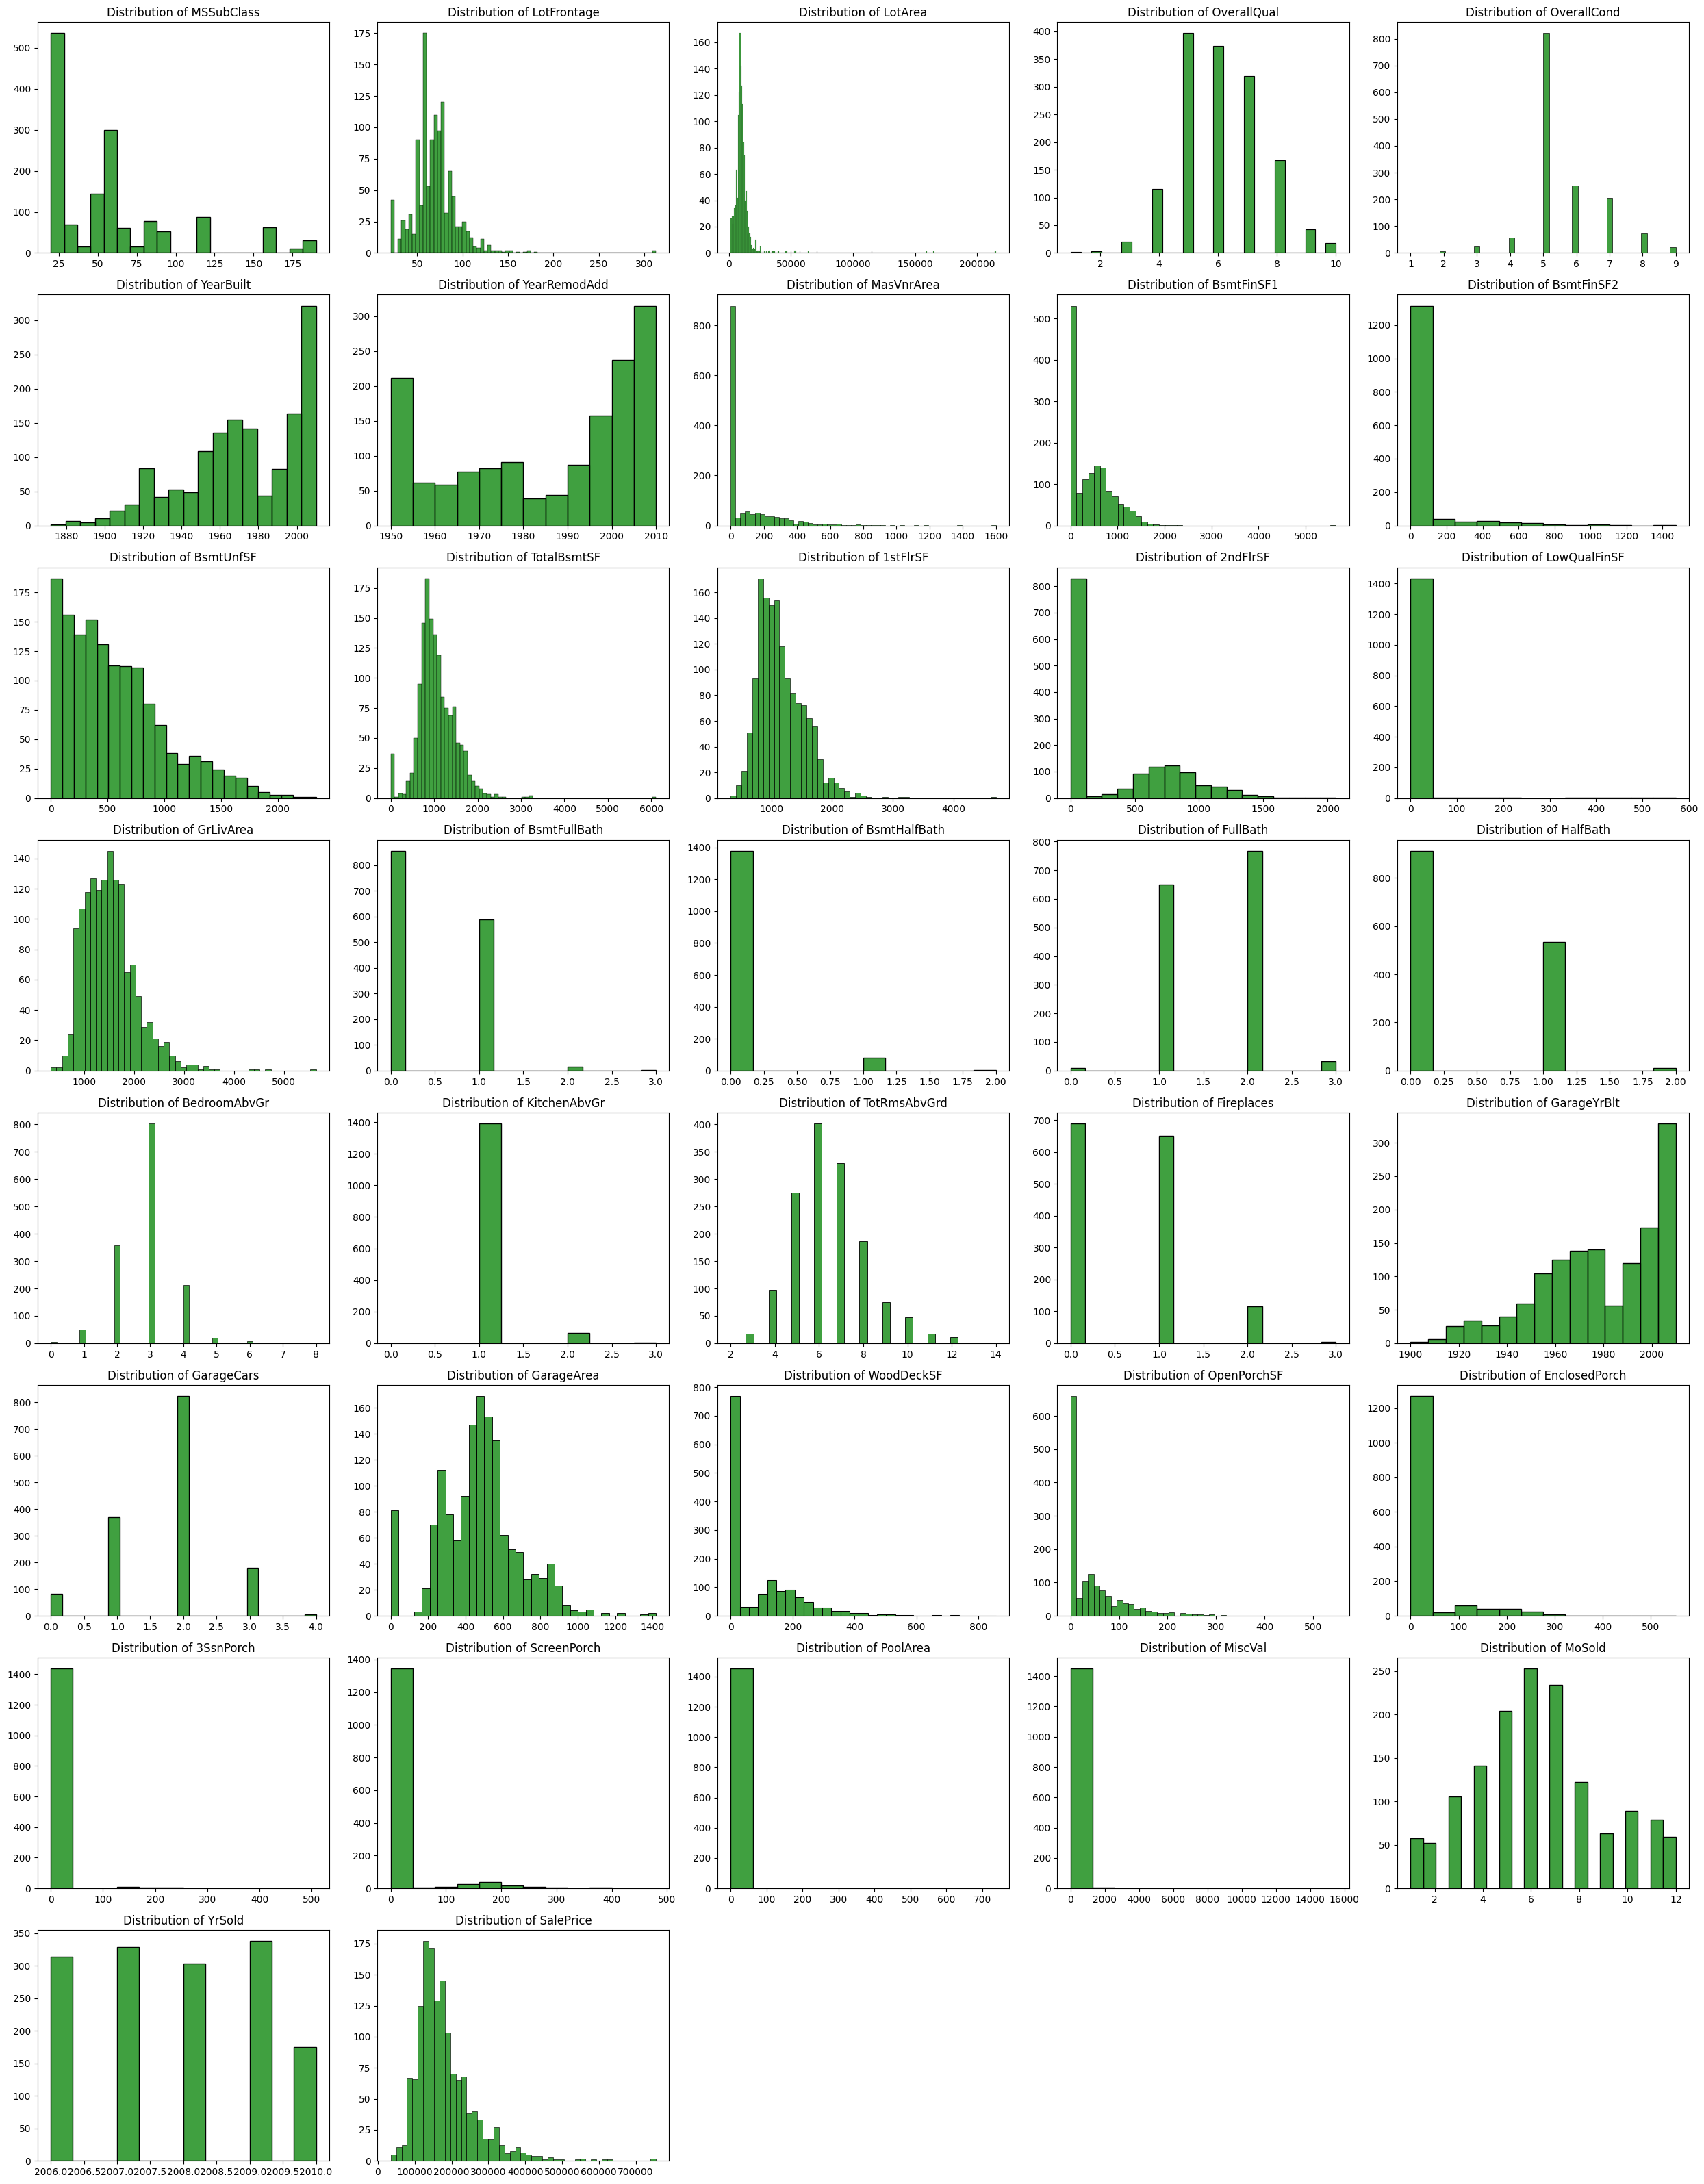

In [25]:
# Selecting only numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Determine the number of rows and columns for the subplot grid
n_cols = 5
n_rows = (len(numeric_cols.columns) + n_cols - 1) // n_cols

# Create a figure with subplots in a grid
plt.figure(figsize=(n_cols * 5, n_rows * 4))  # Adjust size as needed

for index, column in enumerate(numeric_cols.columns):
    plt.subplot(n_rows, n_cols, index + 1)
    sns.histplot(numeric_cols[column], kde=False, color='green')
    plt.title(f'Distribution of {column}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

### 3.3. Add target variable for classification model

In [5]:
print(df.columns.all)


<bound method Index.all of Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond

In [12]:
# Define a function to categorize each house
def categorize_house(row):
    # Determine age category based on Year Built
    if row['YearBuilt'] < 1950:
        age_category = 'Historic'
    elif 1950 <= row['YearBuilt'] < 2000:
        age_category = 'Contemporary'
    else:
        age_category = 'Modern'

    # Determine remodel category based on Year RemodAdd
    if (row['YearRemodAdd'] - row['YearBuilt']) > 20:
        remodel_category = 'Remodeled'
    else:
        remodel_category = 'Not Remodeled'

    # Assign style category based on House Style
    if row['HouseStyle'] in ['2Story', '2.5Unf', '2.5Fin']:
        style_category = 'Multi-Story'
    elif row['HouseStyle'] in ['1Story', '1.5Fin', '1.5Unf']:
        style_category = 'Single-Story'
    elif row['HouseStyle'] == 'SFoyer':
        style_category = 'Split-Foyer'
    elif row['HouseStyle'] == 'SLvl':
        style_category = 'Split-Level'
    else:
        style_category = 'Other'

    # Assign type category based on BldgType
    if row['BldgType'] == '1Fam':
        type_category = 'Single-Family'
    elif row['BldgType'] in ['Twnhs', 'TwnhsE']:
        type_category = 'Townhouse'
    elif row['BldgType'] == 'Duplex':
        type_category = 'Duplex'
    elif row['BldgType'] == '2fmCon':
        type_category = 'Two-Family Conversion'
    else:
        type_category = 'Other'

    # Combine the categories
    return f'{style_category}, {type_category}, {age_category}, {remodel_category}'

# Apply the categorization function to each row
df['HouseCategory'] = df.apply(categorize_house, axis=1)

# Inspect the first few rows of the new column along with other relevant columns
print(df[['HouseStyle', 'BldgType', 'YearBuilt', 'YearRemodAdd', 'HouseCategory']].head())

  HouseStyle BldgType  YearBuilt  YearRemodAdd  \
0     2Story     1Fam       2003          2003   
1     1Story     1Fam       1976          1976   
2     2Story     1Fam       2001          2002   
3     2Story     1Fam       1915          1970   
4     2Story     1Fam       2000          2000   

                                       HouseCategory  
0  Multi-Story, Single-Family, Modern, Not Remodeled  
1  Single-Story, Single-Family, Contemporary, Not...  
2  Multi-Story, Single-Family, Modern, Not Remodeled  
3    Multi-Story, Single-Family, Historic, Remodeled  
4  Multi-Story, Single-Family, Modern, Not Remodeled  


### 3.4. Processing missing values

In [13]:
# Define a threshold for which columns to drop (e.g., if more than 50% of the data is missing)
threshold_to_drop = len(df) * 0.5

# Drop columns with too many missing values
df = df.dropna(thresh=threshold_to_drop, axis=1)

# Impute missing values for numerical columns with the median
numerical_columns = df.select_dtypes(include=['int64', 'float64'])
df[numerical_columns.columns] = numerical_columns.fillna(numerical_columns.median())

# Impute missing values for categorical columns with the mode
categorical_columns = df.select_dtypes(include=['object'])
df[categorical_columns.columns] = categorical_columns.fillna(categorical_columns.mode().iloc[0])

# Check the DataFrame for remaining missing values
missing_values_after = df.isnull().sum()

missing_values_after

<ipython-input-13-f2fae5b2332c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_columns.columns] = numerical_columns.fillna(numerical_columns.median())
<ipython-input-13-f2fae5b2332c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical_columns.columns] = categorical_columns.fillna(categorical_columns.mode().iloc[0])


MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
HouseCategory    0
Length: 76, dtype: int64

### 3.5. Encode the categorical columns

In [14]:
# Select only object (string) data type columns for one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns

# Remove 'HouseCategory' from the columns to encode
categorical_cols = categorical_cols.drop('HouseCategory')

# Apply one-hot encoding to only those categorical columns that are not 'HouseCategory'
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


### 3.6. Normalize numerical variables

In [15]:
# Selecting only numeric columns (excluding 'Id' if it's not relevant to normalization)
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Initialize the Standard Scaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
df[numeric_cols.columns] = scaler.fit_transform(numeric_cols)

In [16]:
print(df.head)

<bound method NDFrame.head of       MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       0.073375    -0.220875 -0.207142     0.651479    -0.517200   1.050994   
1      -0.872563     0.460320 -0.091886    -0.071836     2.179628   0.156734   
2       0.073375    -0.084636  0.073480     0.651479    -0.517200   0.984752   
3       0.309859    -0.447940 -0.096897     0.651479    -0.517200  -1.863632   
4       0.073375     0.641972  0.375148     1.374795    -0.517200   0.951632   
...          ...          ...       ...          ...          ...        ...   
1455    0.073375    -0.357114 -0.260560    -0.071836    -0.517200   0.918511   
1456   -0.872563     0.687385  0.266407    -0.071836     0.381743   0.222975   
1457    0.309859    -0.175462 -0.147810     0.651479     3.078570  -1.002492   
1458   -0.872563    -0.084636 -0.080160    -0.795151     0.381743  -0.704406   
1459   -0.872563     0.233255 -0.058112    -0.795151     0.381743  -0.207594   

      Yea

## 4. Train the model

In [17]:
import torch
import pytorch_lightning as pl
from torch.nn import functional as F
from torch import nn

class MultiTaskModel(pl.LightningModule):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.regression_layer = nn.Linear(64, 1)
        self.classification_layer = nn.Linear(64, num_classes)
        self.val_losses = []

    def forward(self, x):
        x = self.shared_layers(x)
        price = self.regression_layer(x)
        category = self.classification_layer(x)
        return price, category

    def validation_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)

        # Calculate regression and classification losses
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)

        # Log the individual losses
        self.log('val_regression_loss', regression_loss, prog_bar=True)
        self.log('val_classification_loss', classification_loss, prog_bar=True)

        # Append to val_losses for later aggregation
        self.val_losses.append({
            'val_regression_loss': regression_loss.detach(),
            'val_classification_loss': classification_loss.detach(),
            'predicted_price': predicted_price.detach(),
            'price_labels': price_labels.detach()
        })

    def on_validation_epoch_end(self):
        if self.val_losses:
            all_predicted_prices = torch.cat([x['predicted_price'] for x in self.val_losses])
            all_true_prices = torch.cat([x['price_labels'] for x in self.val_losses])

            print("Sample Predictions:", all_predicted_prices[:10])
            print("Sample Actuals:", all_true_prices[:10])

            mse = F.mse_loss(all_predicted_prices, all_true_prices)
            rmse = torch.sqrt(mse)
            mae = F.l1_loss(all_predicted_prices, all_true_prices)


            print(f'Validation Results - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')
        else:
            print('No validation data collected this epoch.')

    def training_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)

        # Calculate losses
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)

        # Combine losses with possible weighting
        total_loss = regression_loss + classification_loss
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

num_features = df.select_dtypes(include=['int64', 'float64']).shape[1]
num_classes = len(df['HouseCategory'].unique())  # Ensure this is pre-processed correctly

# Instantiate the model
model = MultiTaskModel(num_features, num_classes)

# Change the number of input features in the first layer if necessary
model.shared_layers[0] = nn.Linear(233, 128)


## 5. Add Validation and Test Set

In [18]:
from sklearn.preprocessing import LabelEncoder
# Initialize and fit the label encoder on all possible categories
label_encoder = LabelEncoder()
df['HouseCategory'] = label_encoder.fit_transform(df['HouseCategory'].astype(str))

# Splitting data into training and validation (80% train, 20% valid)
X_train, X_valid, y_price_train, y_price_valid, y_category_train, y_category_valid = train_test_split(
    df.drop(['SalePrice', 'HouseCategory'], axis=1),  # features
    df['SalePrice'],  # price labels
    df['HouseCategory'],  # category labels
    test_size=0.2,  # 20% for validation
    random_state=42  # seed for reproducibility
)

# Convert training data to tensors
train_data = TensorDataset(
    torch.tensor(X_train.values.astype(np.float32)),
    torch.tensor(y_price_train.values.astype(np.float32)),
    torch.tensor(y_category_train.values, dtype=torch.long)  # Convert Series to numpy array before tensor conversion
)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Convert validation data to tensors
valid_data = TensorDataset(
    torch.tensor(X_valid.values.astype(np.float32)),
    torch.tensor(y_price_valid.values.astype(np.float32)),
    torch.tensor(y_category_valid.values, dtype=torch.long)  # Convert Series to numpy array before tensor conversion
)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

from pytorch_lightning import Trainer

# Set up the Trainer
trainer = Trainer(max_epochs=10)

# Train the model
trainer.fit(model, train_loader, valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8702771663665771, RMSE: 0.9328864812850952, MAE: 0.7164885997772217


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.8444522619247437, RMSE: 1.3581061363220215, MAE: 0.9883354902267456


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([356])) that is different to the input size (torch.Size([356, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([356])) that is different to the input size (torch.Size([356, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.031956672668457, RMSE: 1.4254671335220337, MAE: 1.0397653579711914


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([648])) that is different to the input size (torch.Size([648, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([648])) that is different to the input size (torch.Size([648, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0081241130828857, RMSE: 1.4170829057693481, MAE: 1.0277748107910156


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([940])) that is different to the input size (torch.Size([940, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([940])) that is different to the input size (torch.Size([940, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.070913076400757, RMSE: 1.439066767692566, MAE: 1.0451635122299194


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([1232])) that is different to the input size (torch.Size([1232, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([1232])) that is different to the input size (torch.Size([1232, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0732481479644775, RMSE: 1.4398778676986694, MAE: 1.04477059841156


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([1524])) that is different to the input size (torch.Size([1524, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([1524])) that is different to the input size (torch.Size([1524, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1070451736450195, RMSE: 1.451566457748413, MAE: 1.0541176795959473


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([1816])) that is different to the input size (torch.Size([1816, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([1816])) that is different to the input size (torch.Size([1816, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1349825859069824, RMSE: 1.4611579179763794, MAE: 1.0603389739990234


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([2108])) that is different to the input size (torch.Size([2108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([2108])) that is different to the input size (torch.Size([2108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.144317150115967, RMSE: 1.4643486738204956, MAE: 1.063323974609375


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([2400])) that is different to the input size (torch.Size([2400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([2400])) that is different to the input size (torch.Size([2400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([2692])) that is different to the input size (torch.Size([2692, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([2692])) that is different to the input size (torch.Size([2692, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation Results - MSE: 2.153960704803467, RMSE: 1.4676377773284912, MAE: 1.0656887292861938


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1402],
        [-0.1899],
        [-0.0833],
        [-0.1646],
        [-0.1787],
        [-0.1025],
        [-0.1557],
        [-0.1637],
        [-0.1529],
        [-0.1492]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])


<ipython-input-17-4ffb036eb463>:53: UserWarning: Using a target size (torch.Size([2984])) that is different to the input size (torch.Size([2984, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-17-4ffb036eb463>:55: UserWarning: Using a target size (torch.Size([2984])) that is different to the input size (torch.Size([2984, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Validation Results - MSE: 2.1529006958007812, RMSE: 1.4672765731811523, MAE: 1.0639703273773193


## 6. Experiments with various activation functions and optimizers

In [20]:
import torch
import pytorch_lightning as pl
from torch.nn import functional as F
from torch import nn

class MultiTaskModel(pl.LightningModule):
    def __init__(self, num_features, num_classes, activation_fn=nn.ReLU, lr=0.001):
        super().__init__()
        self.lr = lr
        self.shared_layers = nn.Sequential(
            nn.Linear(num_features, 128),
            activation_fn(),
            nn.Linear(128, 64),
            activation_fn()
        )
        self.regression_layer = nn.Linear(64, 1)
        self.classification_layer = nn.Linear(64, num_classes)

        # Initialize the val_losses attribute
        self.val_losses = []

    def forward(self, x):
        x = self.shared_layers(x)
        price = self.regression_layer(x)
        category = self.classification_layer(x)
        return price, category

    def validation_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)

        # Calculate regression and classification losses
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)

        # Log the individual losses
        self.log('val_regression_loss', regression_loss, prog_bar=True)
        self.log('val_classification_loss', classification_loss, prog_bar=True)

        # Append to val_losses for later aggregation
        self.val_losses.append({
            'val_regression_loss': regression_loss.detach(),
            'val_classification_loss': classification_loss.detach(),
            'predicted_price': predicted_price.detach(),
            'price_labels': price_labels.detach()
        })

    def on_validation_epoch_end(self):
        if self.val_losses:
            all_predicted_prices = torch.cat([x['predicted_price'] for x in self.val_losses])
            all_true_prices = torch.cat([x['price_labels'] for x in self.val_losses])

            print("Sample Predictions:", all_predicted_prices[:10])
            print("Sample Actuals:", all_true_prices[:10])

            mse = F.mse_loss(all_predicted_prices, all_true_prices)
            rmse = torch.sqrt(mse)
            mae = F.l1_loss(all_predicted_prices, all_true_prices)


            print(f'Validation Results - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')
        else:
            print('No validation data collected this epoch.')

    def training_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)

        # Calculate losses
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)

        # Combine losses with possible weighting
        total_loss = regression_loss + classification_loss
        self.log('train_loss', total_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


from pytorch_lightning import Trainer

activation_functions = [nn.ReLU, nn.LeakyReLU, nn.ELU, nn.PReLU]
learning_rates = [0.01, 0.001, 0.0001]

num_features = 233
num_classes = len(df['HouseCategory'].unique())

for activation_fn in activation_functions:
    for lr in learning_rates:
        # Instantiate the model with a specific activation function and learning rate
        model = MultiTaskModel(num_features, num_classes, activation_fn=activation_fn, lr=lr)
        trainer = Trainer(max_epochs=10)

        print(f"Training with {activation_fn.__name__} and LR={lr}")
        trainer.fit(model, train_loader, valid_loader)
        print(f"Finished training with {activation_fn.__name__} and LR={lr}")


# Instantiate and run the model
model = MultiTaskModel(num_features, num_classes, activation_fn=nn.ReLU)
trainer = Trainer(max_epochs=10)
trainer.fit(model, train_loader, valid_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Training with ReLU and LR=0.01


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8784418106079102, RMSE: 0.9372522830963135, MAE: 0.7607964277267456


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1420445442199707, RMSE: 1.4635725021362305, MAE: 1.0871816873550415


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([356])) that is different to the input size (torch.Size([356, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([356])) that is different to the input size (torch.Size([356, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9357870817184448, RMSE: 1.3913257122039795, MAE: 1.0224202871322632


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([648])) that is different to the input size (torch.Size([648, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([648])) that is different to the input size (torch.Size([648, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.058027505874634, RMSE: 1.4345827102661133, MAE: 1.0454466342926025


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([940])) that is different to the input size (torch.Size([940, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([940])) that is different to the input size (torch.Size([940, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.066746711730957, RMSE: 1.437618374824524, MAE: 1.0444355010986328


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([1232])) that is different to the input size (torch.Size([1232, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([1232])) that is different to the input size (torch.Size([1232, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.118363380432129, RMSE: 1.4554598331451416, MAE: 1.0512648820877075


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([1524])) that is different to the input size (torch.Size([1524, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([1524])) that is different to the input size (torch.Size([1524, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1280934810638428, RMSE: 1.4587986469268799, MAE: 1.0477890968322754


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([1816])) that is different to the input size (torch.Size([1816, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([1816])) that is different to the input size (torch.Size([1816, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.126718044281006, RMSE: 1.4583271741867065, MAE: 1.0446984767913818


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([2108])) that is different to the input size (torch.Size([2108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([2108])) that is different to the input size (torch.Size([2108, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1570029258728027, RMSE: 1.468673825263977, MAE: 1.0547858476638794


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([2400])) that is different to the input size (torch.Size([2400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([2400])) that is different to the input size (torch.Size([2400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1634886264801025, RMSE: 1.4708802700042725, MAE: 1.0551085472106934


<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([2692])) that is different to the input size (torch.Size([2692, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([2692])) that is different to the input size (torch.Size([2692, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)


Validation: |          | 0/? [00:00<?, ?it/s]

<ipython-input-20-d9f0ff5759cd>:56: UserWarning: Using a target size (torch.Size([2984])) that is different to the input size (torch.Size([2984, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(all_predicted_prices, all_true_prices)
<ipython-input-20-d9f0ff5759cd>:58: UserWarning: Using a target size (torch.Size([2984])) that is different to the input size (torch.Size([2984, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(all_predicted_prices, all_true_prices)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Sample Predictions: tensor([[0.0809],
        [0.0765],
        [0.0483],
        [0.0750],
        [0.0809],
        [0.0432],
        [0.0939],
        [0.0686],
        [0.0436],
        [0.1281]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1691882610321045, RMSE: 1.4728164672851562, MAE: 1.055920124053955
Finished training with ReLU and LR=0.01


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Training with ReLU and LR=0.001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8678888082504272, RMSE: 0.9316055178642273, MAE: 0.7461674809455872


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.8079777956008911, RMSE: 1.3446106910705566, MAE: 0.9817945957183838


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9241679906845093, RMSE: 1.387143850326538, MAE: 1.0143851041793823


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9364004135131836, RMSE: 1.3915460109710693, MAE: 1.0149412155151367


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9998304843902588, RMSE: 1.4141535758972168, MAE: 1.029412865638733


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.020212411880493, RMSE: 1.4213417768478394, MAE: 1.0334731340408325


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0257797241210938, RMSE: 1.4232988357543945, MAE: 1.0330337285995483


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.054190158843994, RMSE: 1.4332445859909058, MAE: 1.0409678220748901


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0727956295013428, RMSE: 1.439720630645752, MAE: 1.0443580150604248


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.093445062637329, RMSE: 1.4468742609024048, MAE: 1.0488951206207275


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Sample Predictions: tensor([[0.0473],
        [0.0315],
        [0.0274],
        [0.0209],
        [0.0077],
        [0.0420],
        [0.0202],
        [0.0270],
        [0.0656],
        [0.0442]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0981485843658447, RMSE: 1.4484987258911133, MAE: 1.0491580963134766
Finished training with ReLU and LR=0.001


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Training with ReLU and LR=0.0001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8658324480056763, RMSE: 0.9305011630058289, MAE: 0.7192994356155396


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.160162329673767, RMSE: 1.0771082639694214, MAE: 0.7597244381904602


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.2016428709030151, RMSE: 1.0961947441101074, MAE: 0.7715321779251099


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.2598406076431274, RMSE: 1.1224262714385986, MAE: 0.7925007939338684


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.3690598011016846, RMSE: 1.1700682640075684, MAE: 0.832098126411438


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.4879666566848755, RMSE: 1.2198224067687988, MAE: 0.8740657567977905


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.581836223602295, RMSE: 1.2577106952667236, MAE: 0.9058345556259155


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.6525458097457886, RMSE: 1.2855138778686523, MAE: 0.9291225671768188


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7117204666137695, RMSE: 1.308327317237854, MAE: 0.9480968713760376


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7552845478057861, RMSE: 1.32487154006958, MAE: 0.9615837931632996


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Sample Predictions: tensor([[-0.1221],
        [-0.1002],
        [-0.1067],
        [-0.1146],
        [-0.1065],
        [-0.1796],
        [-0.0880],
        [-0.1032],
        [-0.1740],
        [-0.0865]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7900768518447876, RMSE: 1.337937593460083, MAE: 0.9720920920372009
Finished training with ReLU and LR=0.0001

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)



Training with LeakyReLU and LR=0.01


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.872922420501709, RMSE: 0.9343031644821167, MAE: 0.7541341781616211


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.019343376159668, RMSE: 1.4210360050201416, MAE: 1.0482151508331299


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9667069911956787, RMSE: 1.4023933410644531, MAE: 1.0387486219406128


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0022568702697754, RMSE: 1.4150112867355347, MAE: 1.0433692932128906


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0234029293060303, RMSE: 1.4224636554718018, MAE: 1.0377118587493896


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.08001708984375, RMSE: 1.4422264099121094, MAE: 1.0481988191604614


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0890731811523438, RMSE: 1.4453626871109009, MAE: 1.0455609560012817


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.121190071105957, RMSE: 1.4564305543899536, MAE: 1.053494930267334


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.140976667404175, RMSE: 1.463207721710205, MAE: 1.054556131362915


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1397130489349365, RMSE: 1.4627758264541626, MAE: 1.051819086074829


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Sample Predictions: tensor([[0.0120],
        [0.0449],
        [0.0680],
        [0.0299],
        [0.0184],
        [0.0335],
        [0.0718],
        [0.0326],
        [0.0389],
        [0.0443]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1419646739959717, RMSE: 1.4635452032089233, MAE: 1.0501530170440674
Finished training with LeakyReLU and LR=0.01


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Training with LeakyReLU and LR=0.001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8619792461395264, RMSE: 0.9284283518791199, MAE: 0.7286892533302307


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.814016580581665, RMSE: 1.346854329109192, MAE: 0.9819662570953369


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.030704975128174, RMSE: 1.4250280857086182, MAE: 1.043358325958252


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.059441566467285, RMSE: 1.4350754022598267, MAE: 1.0484569072723389


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.139025926589966, RMSE: 1.462540864944458, MAE: 1.0695446729660034


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1309080123901367, RMSE: 1.4597630500793457, MAE: 1.064918041229248


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1447043418884277, RMSE: 1.4644808769226074, MAE: 1.067322015762329


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1711933612823486, RMSE: 1.4734970331192017, MAE: 1.0728315114974976


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1876912117004395, RMSE: 1.4790846109390259, MAE: 1.0760798454284668


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.187934160232544, RMSE: 1.4791667461395264, MAE: 1.0751384496688843


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Sample Predictions: tensor([[-0.0818],
        [-0.0727],
        [-0.0790],
        [-0.0513],
        [-0.0191],
        [-0.0641],
        [-0.0801],
        [-0.0865],
        [-0.1015],
        [-0.0126]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.184406042098999, RMSE: 1.4779735803604126, MAE: 1.0742905139923096
Finished training with LeakyReLU and LR=0.001


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Training with LeakyReLU and LR=0.0001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8746423125267029, RMSE: 0.9352231621742249, MAE: 0.7563331723213196


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.1669713258743286, RMSE: 1.0802644491195679, MAE: 0.7879598736763


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.2212681770324707, RMSE: 1.1051100492477417, MAE: 0.794694721698761


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.2938766479492188, RMSE: 1.1374869346618652, MAE: 0.8150100708007812


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.4032866954803467, RMSE: 1.1846040487289429, MAE: 0.8527021408081055


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.5074373483657837, RMSE: 1.227777361869812, MAE: 0.8878211379051208


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.59040105342865, RMSE: 1.2611110210418701, MAE: 0.9149052500724792


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.6509854793548584, RMSE: 1.2849067449569702, MAE: 0.9343513250350952


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.699924349784851, RMSE: 1.3038114309310913, MAE: 0.9495554566383362


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7423431873321533, RMSE: 1.3199784755706787, MAE: 0.962487518787384


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Sample Predictions: tensor([[0.0897],
        [0.0748],
        [0.0198],
        [0.0364],
        [0.0831],
        [0.0916],
        [0.0538],
        [0.0144],
        [0.0617],
        [0.0251]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7757079601287842, RMSE: 1.332556962966919, MAE: 0.9722616672515869
Finished training with LeakyReLU and LR=0.0001


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Training with ELU and LR=0.01


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.89165860414505, RMSE: 0.944276750087738, MAE: 0.7721812129020691


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9954148530960083, RMSE: 1.412591576576233, MAE: 1.0417598485946655


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.173306465148926, RMSE: 1.4742138385772705, MAE: 1.0866423845291138


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.169128656387329, RMSE: 1.4727962017059326, MAE: 1.078904151916504


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1998658180236816, RMSE: 1.4831944704055786, MAE: 1.0791411399841309


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.2026889324188232, RMSE: 1.4841458797454834, MAE: 1.0767288208007812


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.2492973804473877, RMSE: 1.4997657537460327, MAE: 1.0831713676452637


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.2485768795013428, RMSE: 1.499525547027588, MAE: 1.0821439027786255


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.2649431228637695, RMSE: 1.5049728155136108, MAE: 1.0864193439483643


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.2267374992370605, RMSE: 1.4922256469726562, MAE: 1.0732918977737427


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Sample Predictions: tensor([[ 0.2157],
        [ 0.1721],
        [-0.0605],
        [ 0.0739],
        [ 0.1143],
        [ 0.0542],
        [ 0.1505],
        [ 0.0756],
        [ 0.0678],
        [ 0.1021]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.2468838691711426, RMSE: 1.4989609718322754, MAE: 1.0772252082824707
Finished training with ELU and LR=0.01
Training with ELU and LR=0.001


INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8830548524856567, RMSE: 0.9397099614143372, MAE: 0.7639432549476624


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.8080850839614868, RMSE: 1.3446505069732666, MAE: 0.989721417427063


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.8795578479766846, RMSE: 1.3709696531295776, MAE: 1.003537654876709


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9785250425338745, RMSE: 1.4066004753112793, MAE: 1.0297040939331055


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.033177375793457, RMSE: 1.4258953332901, MAE: 1.0426782369613647


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0639095306396484, RMSE: 1.4366313219070435, MAE: 1.0493197441101074


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0375349521636963, RMSE: 1.4274225234985352, MAE: 1.0386734008789062


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0422616004943848, RMSE: 1.4290771484375, MAE: 1.038598656654358


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0820682048797607, RMSE: 1.4429373741149902, MAE: 1.048919916152954


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1247270107269287, RMSE: 1.4576443433761597, MAE: 1.0602548122406006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Sample Predictions: tensor([[0.0321],
        [0.0812],
        [0.1299],
        [0.1129],
        [0.0750],
        [0.2336],
        [0.1122],
        [0.0686],
        [0.2721],
        [0.0202]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1263277530670166, RMSE: 1.458193302154541, MAE: 1.0597548484802246
Finished training with ELU and LR=0.001


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Training with ELU and LR=0.0001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.906821608543396, RMSE: 0.9522718191146851, MAE: 0.7857173681259155


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.2161614894866943, RMSE: 1.1027971506118774, MAE: 0.8019087314605713


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.3417391777038574, RMSE: 1.1583346128463745, MAE: 0.8336969614028931


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.4722521305084229, RMSE: 1.2133640050888062, MAE: 0.8753417730331421


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.5744091272354126, RMSE: 1.254754662513733, MAE: 0.9079373478889465


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.6464135646820068, RMSE: 1.2831264734268188, MAE: 0.9308526515960693


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7056405544281006, RMSE: 1.3060017824172974, MAE: 0.9491618275642395


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7512874603271484, RMSE: 1.3233622312545776, MAE: 0.9629760384559631


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7919753789901733, RMSE: 1.3386468887329102, MAE: 0.9751214385032654


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.8229343891143799, RMSE: 1.350160837173462, MAE: 0.9844066500663757


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Sample Predictions: tensor([[0.2237],
        [0.0943],
        [0.1076],
        [0.1423],
        [0.1627],
        [0.2345],
        [0.1131],
        [0.1387],
        [0.2132],
        [0.2747]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.8485430479049683, RMSE: 1.3596113920211792, MAE: 0.9918325543403625
Finished training with ELU and LR=0.0001


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)


Training with PReLU and LR=0.01


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8732175827026367, RMSE: 0.9344611167907715, MAE: 0.7147476673126221


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.3319108486175537, RMSE: 1.527059555053711, MAE: 1.0905005931854248


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1461265087127686, RMSE: 1.4649664163589478, MAE: 1.0387699604034424


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.2227067947387695, RMSE: 1.4908745288848877, MAE: 1.0663573741912842


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1846253871917725, RMSE: 1.4780478477478027, MAE: 1.0614782571792603


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.170888900756836, RMSE: 1.4733936786651611, MAE: 1.059013843536377


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.116563320159912, RMSE: 1.4548413753509521, MAE: 1.0413126945495605


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1086297035217285, RMSE: 1.4521121978759766, MAE: 1.0405126810073853


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.1798670291900635, RMSE: 1.4764373302459717, MAE: 1.0583134889602661


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.232917547225952, RMSE: 1.4942950010299683, MAE: 1.0694724321365356


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Sample Predictions: tensor([[-0.1572],
        [-0.1065],
        [-0.1649],
        [-0.1461],
        [-0.1609],
        [-0.2232],
        [-0.0877],
        [-0.2274],
        [-0.2365],
        [-0.2143]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.2128043174743652, RMSE: 1.4875497817993164, MAE: 1.0642108917236328
Finished training with PReLU and LR=0.01


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)


Training with PReLU and LR=0.001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8986310362815857, RMSE: 0.9479615092277527, MAE: 0.7807150483131409


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7309672832489014, RMSE: 1.3156622648239136, MAE: 0.9558669328689575


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.8109612464904785, RMSE: 1.345719575881958, MAE: 0.9739713072776794


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.891237497329712, RMSE: 1.3752226829528809, MAE: 0.9974616765975952


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.957227110862732, RMSE: 1.399009346961975, MAE: 1.0166380405426025


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9889591932296753, RMSE: 1.4103046655654907, MAE: 1.0235881805419922


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.018505573272705, RMSE: 1.4207412004470825, MAE: 1.0317693948745728


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.998335838317871, RMSE: 1.4136251211166382, MAE: 1.0280086994171143


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.01885724067688, RMSE: 1.4208649396896362, MAE: 1.0335954427719116


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.03749680519104, RMSE: 1.4274091720581055, MAE: 1.038330316543579


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[0.1319],
        [0.1833],
        [0.0757],
        [0.1013],
        [0.1530],
        [0.1116],
        [0.1748],
        [0.1150],
        [0.1046],
        [0.1299]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Validation Results - MSE: 2.034050226211548, RMSE: 1.426201343536377, MAE: 1.0363870859146118
Finished training with PReLU and LR=0.001


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)


Training with PReLU and LR=0.0001


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8719163537025452, RMSE: 0.933764636516571, MAE: 0.7518252730369568


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.1635602712631226, RMSE: 1.0786845684051514, MAE: 0.784942626953125


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.2226096391677856, RMSE: 1.1057168245315552, MAE: 0.7957102060317993


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.311773657798767, RMSE: 1.145326852798462, MAE: 0.8219205737113953


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.4322047233581543, RMSE: 1.1967475414276123, MAE: 0.8626108169555664


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.5395616292953491, RMSE: 1.2407907247543335, MAE: 0.8985705971717834


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.6189348697662354, RMSE: 1.2723736763000488, MAE: 0.9245033860206604


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.6748600006103516, RMSE: 1.2941638231277466, MAE: 0.9421033263206482


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.720953106880188, RMSE: 1.3118510246276855, MAE: 0.9564034938812256


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7558979988098145, RMSE: 1.3251030445098877, MAE: 0.9668982625007629


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[ 0.0104],
        [-0.0156],
        [ 0.1013],
        [ 0.0717],
        [-0.0558],
        [ 0.0532],
        [-0.0027],
        [ 0.0678],
        [ 0.0494],
        [ 0.0655]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Validation Results - MSE: 1.7847939729690552, RMSE: 1.3359618186950684, MAE: 0.9755757451057434
Finished training with PReLU and LR=0.0001


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.163     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 0.8630213141441345, RMSE: 0.9289894104003906, MAE: 0.7272806167602539


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.7982877492904663, RMSE: 1.3410024642944336, MAE: 0.9791317582130432


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9370702505111694, RMSE: 1.3917866945266724, MAE: 1.0144782066345215


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9471696615219116, RMSE: 1.395410180091858, MAE: 1.0137137174606323


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 1.9947986602783203, RMSE: 1.412373423576355, MAE: 1.0255546569824219


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.038796901702881, RMSE: 1.4278644323349, MAE: 1.0366944074630737


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.0693745613098145, RMSE: 1.4385321140289307, MAE: 1.0448968410491943


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.06680965423584, RMSE: 1.4376403093338013, MAE: 1.0427086353302002


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.082115411758423, RMSE: 1.4429537057876587, MAE: 1.046103596687317


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])
Validation Results - MSE: 2.096207857131958, RMSE: 1.4478286504745483, MAE: 1.0495465993881226


Validation: |          | 0/? [00:00<?, ?it/s]

Sample Predictions: tensor([[-0.0644],
        [-0.0835],
        [-0.0170],
        [-0.1016],
        [-0.0970],
        [-0.0414],
        [-0.1510],
        [-0.0928],
        [-0.0457],
        [-0.0328]])
Sample Actuals: tensor([-0.3327,  1.8142, -0.8301, -0.2760,  1.6946, -1.3275,  1.6443, -0.4397,
        -1.2141, -0.5719])


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Validation Results - MSE: 2.1142520904541016, RMSE: 1.4540468454360962, MAE: 1.0537924766540527


### 6.1. Finding: Training with PReLU and LR=0.001 as using them the model has the best performance

In [134]:
class MultiTaskModel(pl.LightningModule):
    def __init__(self, num_features, num_classes, activation_fn=nn.PReLU, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.shared_layers = nn.Sequential(
            nn.Linear(num_features, 128),
            activation_fn(),
            nn.Linear(128, 64),
            activation_fn()
        )
        self.regression_layer = nn.Linear(64, 1)
        self.classification_layer = nn.Linear(64, num_classes)

    def training_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)
        total_loss = regression_loss + classification_loss
        self.log('train_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)
        val_loss = regression_loss + classification_loss
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True)
        acc = accuracy_score(category_labels.cpu().numpy(), torch.argmax(predicted_category, dim=1).cpu().numpy())
        self.log('val_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        return {'val_loss': val_loss, 'val_accuracy': acc}


    def forward(self, x):
        x = self.shared_layers(x)
        price = self.regression_layer(x)
        category = self.classification_layer(x)
        return price, category

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


# Setup trainer

num_features = 233
num_classes = len(df['HouseCategory'].unique())

trainer = pl.Trainer(max_epochs=10)
model = MultiTaskModel(num_features, num_classes)
trainer.fit(model, train_loader, valid_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### 6.2. Post-Experiments Model Performance with PReLU and LR=0.001

In [135]:

# Evaluate the model
model.eval()

# Initialize lists to store predictions and labels
regression_predictions = []
regression_labels = []
classification_predictions = []
classification_labels = []

# Iterate over the validation loader
for batch in valid_loader:
    data, price_labels, category_labels = batch

    # Forward pass
    predicted_price, predicted_category = model(data)

    # Collect predictions and labels for regression
    regression_predictions.extend(predicted_price.squeeze().tolist())
    regression_labels.extend(price_labels.tolist())

    # Collect predictions and labels for classification
    classification_predictions.extend(torch.argmax(predicted_category, dim=1).tolist())
    classification_labels.extend(category_labels.tolist())

# Calculate regression metrics
regression_mse = mean_squared_error(regression_labels, regression_predictions)
regression_rmse = np.sqrt(regression_mse)
regression_mae = mean_absolute_error(regression_labels, regression_predictions)

print("Regression Metrics:")
print(f"MSE: {regression_mse}")
print(f"RMSE: {regression_rmse}")
print(f"MAE: {regression_mae}")

# Calculate classification metrics
classification_report_output = classification_report(classification_labels, classification_predictions)
accuracy = accuracy_score(classification_labels, classification_predictions)

print("\nClassification Report:")
print(classification_report_output)
print(f"Accuracy: {accuracy}")

# Set the model back to training mode
model.train()


Regression Metrics:
MSE: 0.17662177694743766
RMSE: 0.42026393724353467
MAE: 0.2992868734713427

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           2       0.91      0.94      0.92        31
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         2
           5       0.80      0.89      0.84         9
           6       0.93      0.96      0.94        26
           7       0.90      0.82      0.86        11
           8       0.00      0.00      0.00         1
           9       0.50      1.00      0.67         2
          11       0.00      0.00      0.00         1
          12       0.88      1.00      0.93         7
          16       0.91      0.87      0.89        60
          17       0.85      0.61      0.71        18
          18       0.60      0.75      0.67        12
          19       0.84      0.86      0.85        37
          20    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

MultiTaskModel(
  (shared_layers): Sequential(
    (0): Linear(in_features=233, out_features=128, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): PReLU(num_parameters=1)
  )
  (regression_layer): Linear(in_features=64, out_features=1, bias=True)
  (classification_layer): Linear(in_features=64, out_features=40, bias=True)
)

### 6.3. Post Experiments Model Performance - Regression Performance Metrics

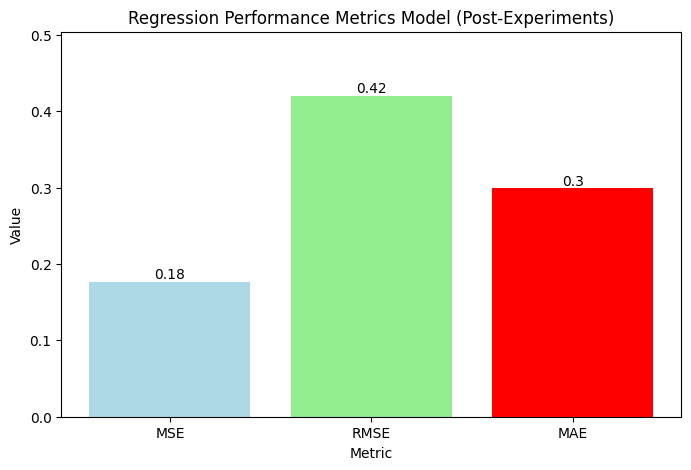

In [141]:
# Values for metrics
metrics_values = [regression_mse, regression_rmse, regression_mae]
metrics_names = ['MSE', 'RMSE', 'MAE']

# Create the bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics_names, metrics_values, color=['lightblue', 'lightgreen', 'red'])

# Adding data labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2),
             va='bottom', ha='center', fontsize=10, color='black')

# Adding labels and title
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Regression Performance Metrics Model (Post-Experiments)')
plt.ylim(0, max(metrics_values) * 1.2)  # Set y-axis limit to be 20% higher than the max value for better visualization

plt.show()

### 6.4. Post Experiments Model Performance - Regression Model Performance Visualizations

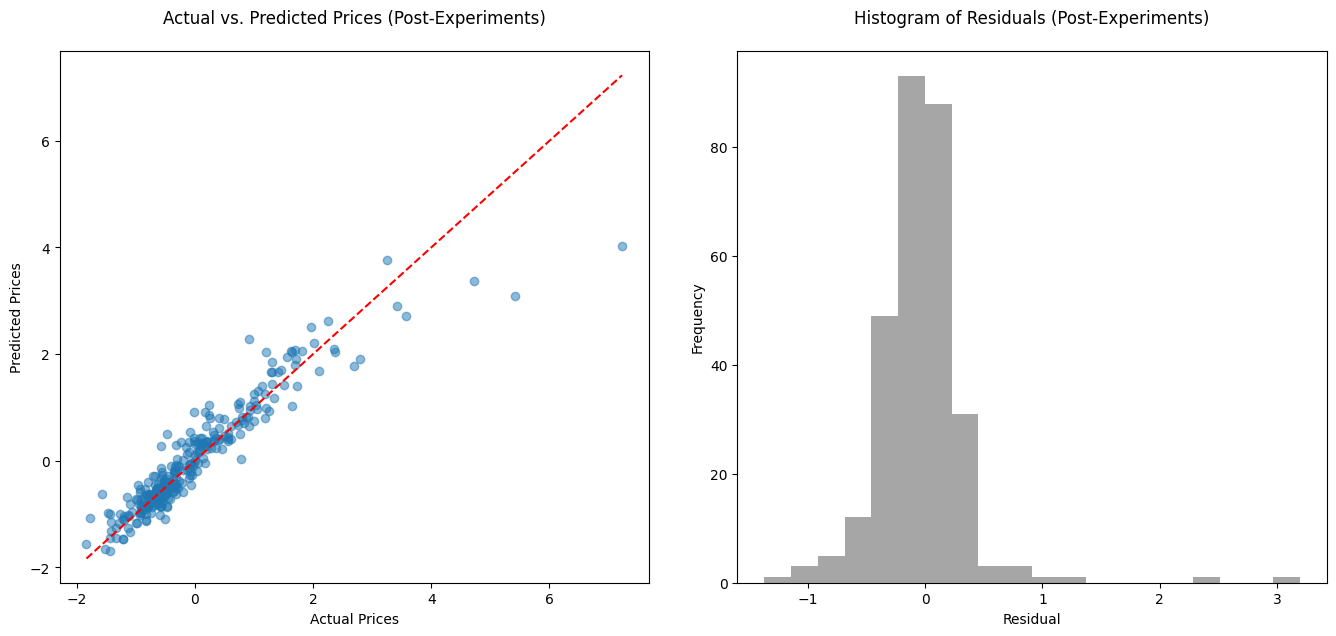

In [137]:
# Increase the figure size to give more room for titles
plt.figure(figsize=(14, 7))  # Adjust the width and height if needed

# Scatter plot for actual vs predicted prices
plt.subplot(1, 2, 1)
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
# Increase padding for the title to prevent overlap
plt.title('Actual vs. Predicted Prices (Post-Experiments)', pad=20)
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], 'r--')  # Ideal line

# Histogram of the residuals
plt.subplot(1, 2, 2)
residuals = np.array(actual_prices) - np.array(predicted_prices)
plt.hist(residuals, bins=20, color='gray', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
# Increase padding for the title to prevent overlap
plt.title('Histogram of Residuals (Post-Experiments)', pad=20)

# Adjust the layout to prevent any clipping of tick labels or titles
plt.tight_layout(pad=3.0)  # Adjust padding as necessary

plt.show()

### 6.5. Post Experiments Model Performance - Classifcation Report Heatmap

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

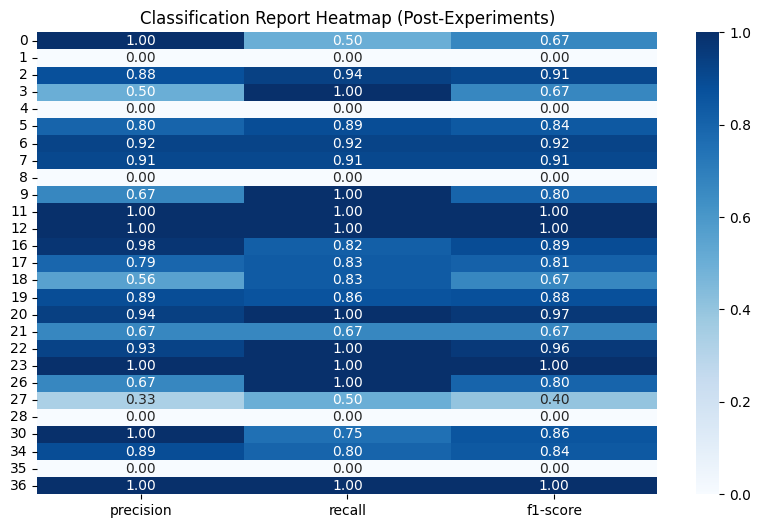

In [138]:

# Parse the classification report into a DataFrame
report = classification_report(actual_categories, predicted_categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Heatmap of the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap='Blues', fmt=".2f")  # Exclude 'accuracy' and support
plt.title('Classification Report Heatmap (Post-Experiments)')
plt.show()


## 7. Tuning Model with Advanced PyTorch Lightning Features and Combine the loss function from both models into a single loss function for training multi-task model

In [142]:
class MultiTaskModel(pl.LightningModule):
    def __init__(self, num_features, num_classes, activation_fn=nn.PReLU, lr=0.001, loss_weights={'regression': 0.5, 'classification': 0.5}):
        super().__init__()
        self.save_hyperparameters()
        self.shared_layers = nn.Sequential(
            nn.Linear(num_features, 128),
            activation_fn(),
            nn.Linear(128, 64),
            activation_fn()
        )
        self.regression_layer = nn.Linear(64, 1)
        self.classification_layer = nn.Linear(64, num_classes)
        self.loss_weights = loss_weights

    def forward(self, x):
        x = self.shared_layers(x)
        price = self.regression_layer(x)
        category = self.classification_layer(x)
        return price, category

    def training_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)
        # Combine losses with respective weights
        total_loss = self.loss_weights['regression'] * regression_loss + self.loss_weights['classification'] * classification_loss
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)
        val_loss = self.loss_weights['regression'] * regression_loss + self.loss_weights['classification'] * classification_loss
        self.log('val_loss', val_loss, prog_bar=True)
        # Optionally log other metrics
        self.log('val_regression_loss', regression_loss, prog_bar=True)
        self.log('val_classification_loss', classification_loss, prog_bar=True)
        return {'val_loss': val_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

# Setup trainer
num_features = 233
num_classes = len(df['HouseCategory'].unique())

logger = TensorBoardLogger("logs", name="MultiTaskModel")
checkpoint_callback = ModelCheckpoint(monitor='val_loss')  # Monitor the logged validation loss
early_stopping_callback = EarlyStopping(monitor='val_regression_loss', patience=5)

trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[checkpoint_callback, early_stopping_callback])
model = MultiTaskModel(num_features, num_classes)
trainer.fit(model, train_loader, valid_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type       | Params
----------------------------------------------------
0 | shared_layers        | Sequential | 38.2 K
1 | regression_layer     | Linear     | 65    
2 | classification_layer | Linear     | 2.6 K 
----------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### 7.1. Model Performance

In [143]:
# After training
model.eval()

# Lists to store predictions and labels
predicted_prices = []
predicted_categories = []
actual_prices = []
actual_categories = []

with torch.no_grad():
    for data, price_labels, category_labels in valid_loader:
        predicted_price, predicted_category = model(data)
        predicted_prices.extend(predicted_price.squeeze().tolist())
        predicted_categories.extend(torch.argmax(predicted_category, dim=1).tolist())
        actual_prices.extend(price_labels.tolist())
        actual_categories.extend(category_labels.tolist())

# Calculate additional evaluation metrics
from sklearn.metrics import mean_squared_error, classification_report

# Regression metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)  # Calculate RMSE
mae = mean_absolute_error(actual_prices, predicted_prices)  # Calculate MAE

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

# Classification metrics
classification_report_str = classification_report(actual_categories, predicted_categories)
print("Classification Report:\n", classification_report_str)


Mean Squared Error (MSE): 0.16385301050852952
Root Mean Squared Error (RMSE): 0.40478761160456667
Mean Absolute Error (MAE): 0.24616823205325675
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         0
           2       0.93      0.87      0.90        31
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         2
           5       0.78      0.78      0.78         9
           6       0.87      1.00      0.93        26
           7       0.90      0.82      0.86        11
           8       0.00      0.00      0.00         1
           9       0.50      1.00      0.67         2
          11       1.00      1.00      1.00         1
          12       0.78      1.00      0.88         7
          16       0.91      0.88      0.90        60
          17       0.93      0.72      0.81        18
          18       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

### 7.2. Model with Advanced PyTorch Lightning Features - Regression Performance Metrics

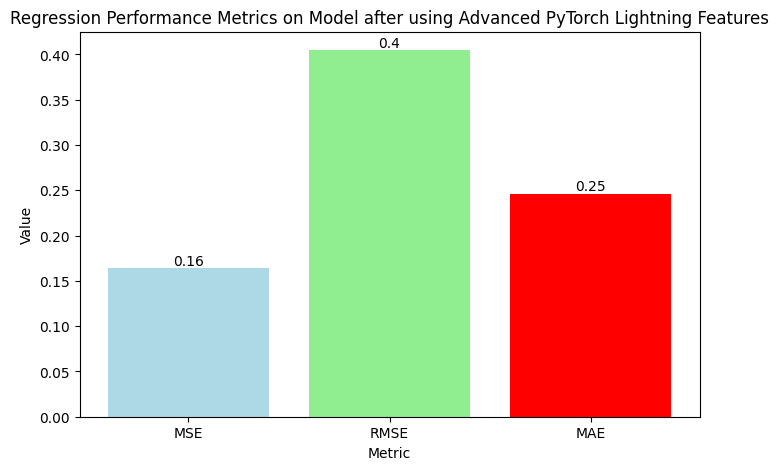

In [144]:
# Values
metrics_values = [mse, rmse, mae]
metrics_names = ['MSE', 'RMSE', 'MAE']

# Creating the bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics_names, metrics_values, color=['lightblue', 'lightgreen', 'red'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Regression Performance Metrics on Model after using Advanced PyTorch Lightning Features')

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')  # Vertically align at bottom, horizontally align at center

plt.show()

### 7.3. Model Performance with Advanced Pytorch Lightning - Regression Model Performance Visualizations

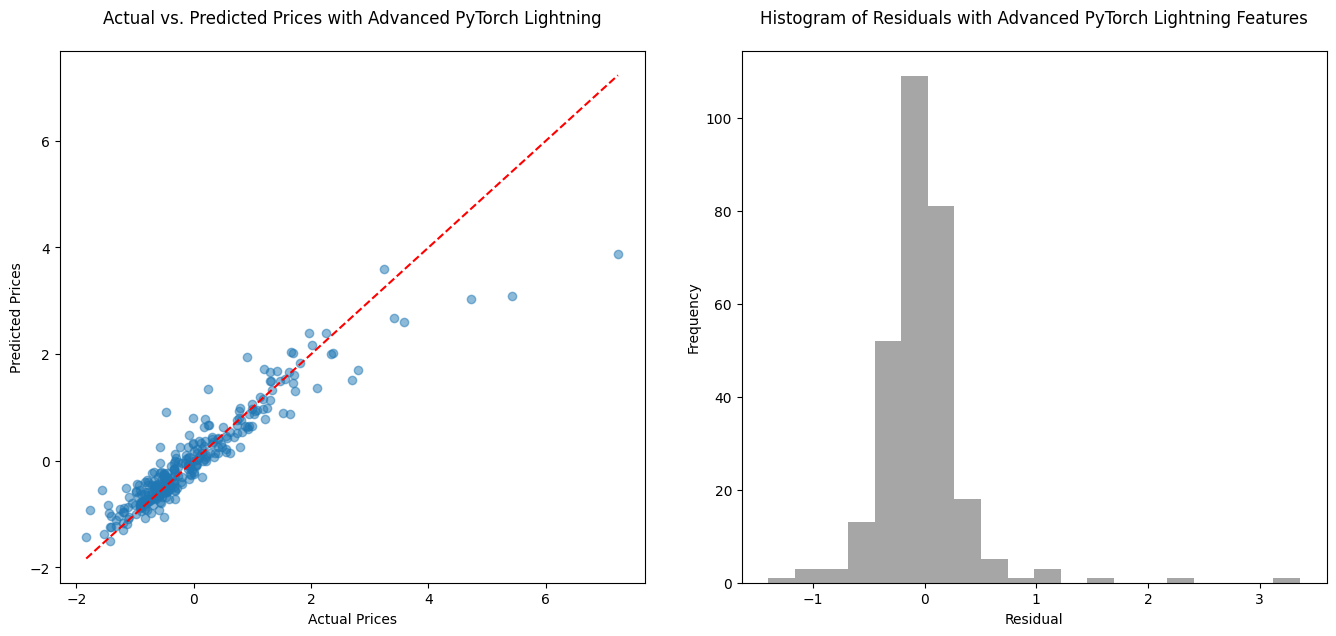

In [145]:
plt.figure(figsize=(14, 7))  # Increase the width of the figure

# Scatter plot for actual vs predicted prices
plt.subplot(1, 2, 1)
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices with Advanced PyTorch Lightning', pad=20)
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], 'r--')  # Ideal line

# Histogram of the residuals
plt.subplot(1, 2, 2)
residuals = np.array(actual_prices) - np.array(predicted_prices)
plt.hist(residuals, bins=20, color='gray', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals with Advanced PyTorch Lightning Features', pad=20)

plt.tight_layout(pad=3.0)  # Adjust layout to make more space
plt.show()

### 7.4. Model Performance with Advanced Pytorch Lightning - Classification Report Heatmap


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

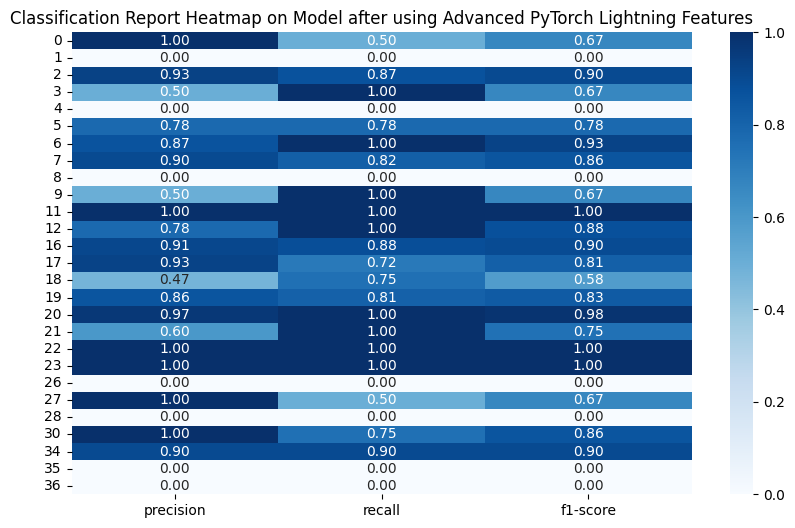

In [146]:


# Parse the classification report into a DataFrame
report = classification_report(actual_categories, predicted_categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Heatmap of the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap='Blues', fmt=".2f")  # Exclude 'accuracy' and support
plt.title('Classification Report Heatmap on Model after using Advanced PyTorch Lightning Features')
plt.show()


## 8. Hyperparameter Tuning: Use PyTorch Lightning's integration with Optuna for hyperparameter optimization

In [154]:
class MultiTaskModel(pl.LightningModule):
    def __init__(self, num_features, num_classes, lr, layer_sizes, regression_weight=0.5, classification_weight=0.5):
        super().__init__()
        self.save_hyperparameters()

        # Layer setup
        layers = []
        in_features = num_features
        for size in layer_sizes:
            layers.append(nn.Linear(in_features, size))
            layers.append(nn.PReLU())
            layers.append(nn.Dropout(0.2))
            in_features = size
        self.shared_layers = nn.Sequential(*layers)
        self.regression_layer = nn.Linear(in_features, 1)
        self.classification_layer = nn.Linear(in_features, num_classes)

        # Metrics
        if num_classes > 1:
            self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        else:
            self.accuracy = Accuracy(average='macro', task='binary')

        # Loss weights
        self.regression_weight = regression_weight
        self.classification_weight = classification_weight

    def forward(self, x):
        x = self.shared_layers(x)
        price = self.regression_layer(x)
        category = self.classification_layer(x)
        return price, category

    def training_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)
        total_loss = self.regression_weight * regression_loss + self.classification_weight * classification_loss
        self.log('train_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.accuracy(torch.argmax(predicted_category, dim=1), category_labels), on_step=False, on_epoch=True, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)
        val_loss = self.regression_weight * regression_loss + self.classification_weight * classification_loss
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.accuracy(torch.argmax(predicted_category, dim=1), category_labels), on_step=False, on_epoch=True, prog_bar=True)
        return {'val_loss': val_loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


class MyEarlyStopping(pl.callbacks.Callback):
    def __init__(self, monitor='val_loss', patience=3, min_delta=0.01):
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.wait = 0
        self.stopped_epoch = 0

    def on_validation_end(self, trainer, pl_module):
        current = trainer.callback_metrics.get(self.monitor)
        if current is None:
            return
        if self.best_score is None or self.best_score > current + self.min_delta:
            self.best_score = current
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = trainer.current_epoch
                trainer.should_stop = True
                print(f"Early stopping triggered at epoch {self.stopped_epoch}")

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    layer_sizes = [trial.suggest_categorical('n_units_l{}'.format(i), [64, 128, 256]) for i in range(trial.suggest_int('n_layers', 1, 3))]

    model = MultiTaskModel(num_features=233, num_classes=num_classes, lr=lr, layer_sizes=layer_sizes)
    logger = TensorBoardLogger("logs", name="Optuna_Tune")
    checkpoint_callback = ModelCheckpoint(dirpath="checkpoints", monitor="val_loss")
    my_early_stopping = MyEarlyStopping(monitor='val_loss', patience=3)

    trainer = Trainer(
        logger=logger,
        callbacks=[checkpoint_callback, my_early_stopping],
        max_epochs=10
    )

    trainer.fit(model, train_loader, valid_loader)
    best_score = checkpoint_callback.best_model_score if checkpoint_callback.best_model_score else float('inf')
    return best_score
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10, timeout=3600)
    print("Best trial:")
    print(f"  Value: {study.best_trial.value}")
    for key, value in study.best_trial.params.items():
        print(f"{key}: {value}")


[I 2024-04-20 06:03:20,064] A new study created in memory with name: no-name-03568396-e9c3-4f56-b210-8d4ba94e6821
<ipython-input-154-68a400d399d3>:82: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-04-20 06:03:34,816] Trial 0 finished with value: 0.2571089267730713 and parameters: {'lr': 0.0007576267934200047, 'n_layers': 3, 'n_units_l0': 256, 'n_units_l1': 128, 'n_units_l2': 256}. Best is trial 0 with value: 0.2571089267730713.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 54.7 K
1 | regression_layer     | Linear             | 65    
2 | classification_layer | Linear             | 2.6 K 
3 | accuracy      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-04-20 06:03:43,857] Trial 1 finished with value: 0.24540741741657257 and parameters: {'lr': 0.0028545627033560875, 'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 64}. Best is trial 1 with value: 0.24540741741657257.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 15.0 K
1 | regression_layer     | Linear             | 65    
2 | classification_layer | Linear             | 2.6 K 
3 | accuracy     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-04-20 06:03:51,725] Trial 2 finished with value: 0.2927561402320862 and parameters: {'lr': 0.001988098845924201, 'n_layers': 1, 'n_units_l0': 64}. Best is trial 1 with value: 0.24540741741657257.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 54.7 K
1 | regression_layer     | Linear             | 65    
2 | classification_layer | Linear             | 2.6 K 
3 | accuracy             | MulticlassAccuracy | 0     
--

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-20 06:03:54,702] Trial 3 finished with value: 2.4404172897338867 and parameters: {'lr': 1.529734056742353e-05, 'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 128, 'n_units_l2': 64}. Best is trial 1 with value: 0.24540741741657257.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 128 K 
1 | regression_layer     | Linear             | 257   
2 | classification_layer | Linear             | 10.3 K
3 | accuracy             | MulticlassAccuracy | 0     
------------------------------------------------------

Early stopping triggered at epoch 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-04-20 06:04:04,231] Trial 4 finished with value: 1.211429238319397 and parameters: {'lr': 5.587740963670252e-05, 'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 256, 'n_units_l2': 256}. Best is trial 1 with value: 0.24540741741657257.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 128 K 
1 | regression_layer     | Linear             | 257   
2 | classification_layer | Linear             | 10.3 K
3 | accuracy      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-20 06:04:07,457] Trial 5 finished with value: 2.3470540046691895 and parameters: {'lr': 2.2661002664656594e-05, 'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 256, 'n_units_l2': 256}. Best is trial 1 with value: 0.24540741741657257.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 30.0 K
1 | regression_layer     | Linear             | 129   
2 | classification_layer | Linear             | 5.2 K 
3 | accuracy             | MulticlassAccuracy | 0     
----------------------------------------------------

Early stopping triggered at epoch 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-20 06:04:14,169] Trial 6 finished with value: 0.5714950561523438 and parameters: {'lr': 0.047620958394544916, 'n_layers': 1, 'n_units_l0': 128}. Best is trial 1 with value: 0.24540741741657257.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 59.9 K
1 | regression_layer     | Linear             | 257   
2 | classification_layer | Linear             | 10.3 K
3 | accuracy             | MulticlassAccuracy | 0     
------------------------------------------------------------
70.4 K    Trainable params
0   

Early stopping triggered at epoch 7


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-04-20 06:04:16,610] Trial 7 finished with value: 2.8585262298583984 and parameters: {'lr': 0.09963804676412281, 'n_layers': 1, 'n_units_l0': 256}. Best is trial 1 with value: 0.24540741741657257.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 19.1 K
1 | regression_layer     | Linear             | 65    
2 | classification_layer | Linear             | 2.6 K 
3 | accuracy             | MulticlassAccuracy | 0     
------------------------------------------------------------
21.8 K    Trainable params
0    

Early stopping triggered at epoch 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-04-20 06:04:24,674] Trial 8 finished with value: 1.0983514785766602 and parameters: {'lr': 0.00018295900583949225, 'n_layers': 2, 'n_units_l0': 64, 'n_units_l1': 64}. Best is trial 1 with value: 0.24540741741657257.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 95.9 K
1 | regression_layer     | Linear             | 129   
2 | classification_layer | Linear             | 5.2 K 
3 | accuracy             | Multiclass

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-04-20 06:04:34,607] Trial 9 finished with value: 0.30798012018203735 and parameters: {'lr': 0.0007637026123466824, 'n_layers': 3, 'n_units_l0': 128, 'n_units_l1': 256, 'n_units_l2': 128}. Best is trial 1 with value: 0.24540741741657257.


Best trial:
  Value: 0.24540741741657257
lr: 0.0028545627033560875
n_layers: 3
n_units_l0: 128
n_units_l1: 128
n_units_l2: 64


Conclusion: after tuning, the best trail shows that:

* lr: 0.0028545627033560875

* n_layers: 3

* n_units_l0: 128

* n_units_l1: 128

* n_units_l2: 64

will have the best performance of the mode. Therefore, the below shows the final best model.

### 8.1. The Optimal Model Training with the Parameters that Selected from Optuna Tuning

In [161]:
class MultiTaskModel(pl.LightningModule):
    def __init__(self, num_features, num_classes, lr, layer_sizes, regression_weight=0.5, classification_weight=0.5):
        super().__init__()
        self.save_hyperparameters()

        layers = []
        in_features = num_features
        for size in layer_sizes:
            layers.append(nn.Linear(in_features, size))
            layers.append(nn.PReLU())
            layers.append(nn.Dropout(0.2))  # Example fixed dropout
            in_features = size
        self.shared_layers = nn.Sequential(*layers)
        self.regression_layer = nn.Linear(in_features, 1)
        self.classification_layer = nn.Linear(in_features, num_classes)

        self.accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')

        self.regression_weight = regression_weight
        self.classification_weight = classification_weight

    def forward(self, x):
        x = self.shared_layers(x)
        price = self.regression_layer(x)
        category = self.classification_layer(x)
        return price, category

    def training_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)
        total_loss = self.regression_weight * regression_loss + self.classification_weight * classification_loss
        self.log('train_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.accuracy(torch.argmax(predicted_category, dim=1), category_labels), on_step=False, on_epoch=True, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        data, price_labels, category_labels = batch
        predicted_price, predicted_category = self(data)
        regression_loss = F.mse_loss(predicted_price.squeeze(), price_labels)
        classification_loss = F.cross_entropy(predicted_category, category_labels)
        val_loss = self.regression_weight * regression_loss + self.classification_weight * classification_loss

        # Log the regression loss specifically for early stopping
        self.log('val_regression_loss', regression_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_loss', val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return {'val_loss': val_loss, 'val_regression_loss': regression_loss}


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

# Parameters from hyperparameter optimization
optimal_lr = 0.0028545627033560875
optimal_layer_sizes = [128, 128, 64]  # Corresponding to n_units_l0, n_units_l1, n_units_l2

# Num_features and num_classes are defined as follows:
num_features = 233
num_classes = len(df['HouseCategory'].unique())

# Instantiate model with optimal parameters
model = MultiTaskModel(num_features=num_features, num_classes=num_classes, lr=optimal_lr, layer_sizes=optimal_layer_sizes)

# Trainer setup
logger = TensorBoardLogger("logs", name="MultiTaskModel")
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
early_stopping_callback = EarlyStopping(monitor='val_regression_loss', patience=5)

trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[checkpoint_callback, early_stopping_callback])
trainer.fit(model, train_loader, valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type               | Params
------------------------------------------------------------
0 | shared_layers        | Sequential         | 54.7 K
1 | regression_layer     | Linear             | 65    
2 | classification_layer | Linear             | 2.6 K 
3 | accuracy             | MulticlassAccuracy | 0     
------------------------------------------------------------
57.4 K    Trainable params
0         Non-trainable params
57.4 K    Total params
0.230     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


### 8.2. Optuna Model Performance

In [164]:
# After training
model.eval()

# Lists to store predictions and labels
predicted_prices = []
predicted_categories = []
actual_prices = []
actual_categories = []

with torch.no_grad():
    for data, price_labels, category_labels in valid_loader:
        predicted_price, predicted_category = model(data)
        predicted_prices.extend(predicted_price.squeeze().tolist())
        predicted_categories.extend(torch.argmax(predicted_category, dim=1).tolist())
        actual_prices.extend(price_labels.tolist())
        actual_categories.extend(category_labels.tolist())

# Calculate additional evaluation metrics
from sklearn.metrics import mean_squared_error, classification_report

# Regression metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)  # Calculate RMSE
mae = mean_absolute_error(actual_prices, predicted_prices)  # Calculate MAE

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

# Classification metrics
classification_report_str = classification_report(actual_categories, predicted_categories)
print("Classification Report:\n", classification_report_str)


Mean Squared Error (MSE): 0.1549119715837572
Root Mean Squared Error (RMSE): 0.3935885816226853
Mean Absolute Error (MAE): 0.23403652598491348
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         0
           2       0.91      1.00      0.95        31
           3       0.33      1.00      0.50         1
           4       0.00      0.00      0.00         2
           5       0.64      1.00      0.78         9
           6       1.00      0.88      0.94        26
           7       0.85      1.00      0.92        11
           8       0.00      0.00      0.00         1
           9       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         1
          12       0.88      1.00      0.93         7
          16       0.95      0.87      0.90        60
          17       0.93      0.78      0.85        18
          18       0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

### 8.3. Optuna Model (Final Model) - Regression Performance Metrics

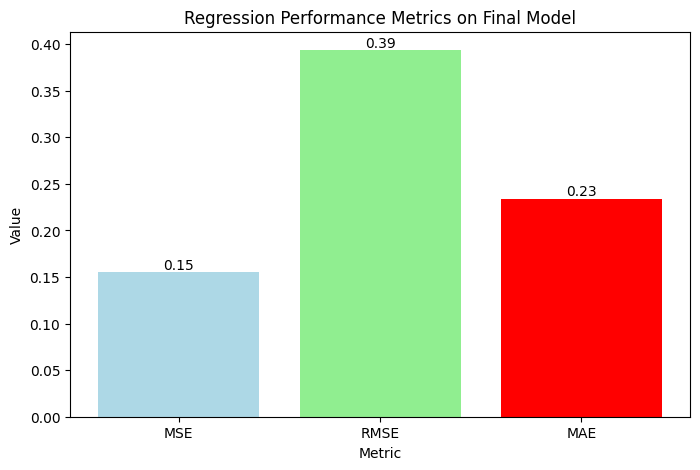

In [163]:
# Values
metrics_values = [mse, rmse, mae]
metrics_names = ['MSE', 'RMSE', 'MAE']

# Creating the bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics_names, metrics_values, color=['lightblue', 'lightgreen', 'red'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Regression Performance Metrics on Final Model')

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')  # Vertically align at bottom, horizontally align at center

plt.show()


### 8.4. Optuna Model (Final Model) - Regression Model Performance Visualizations

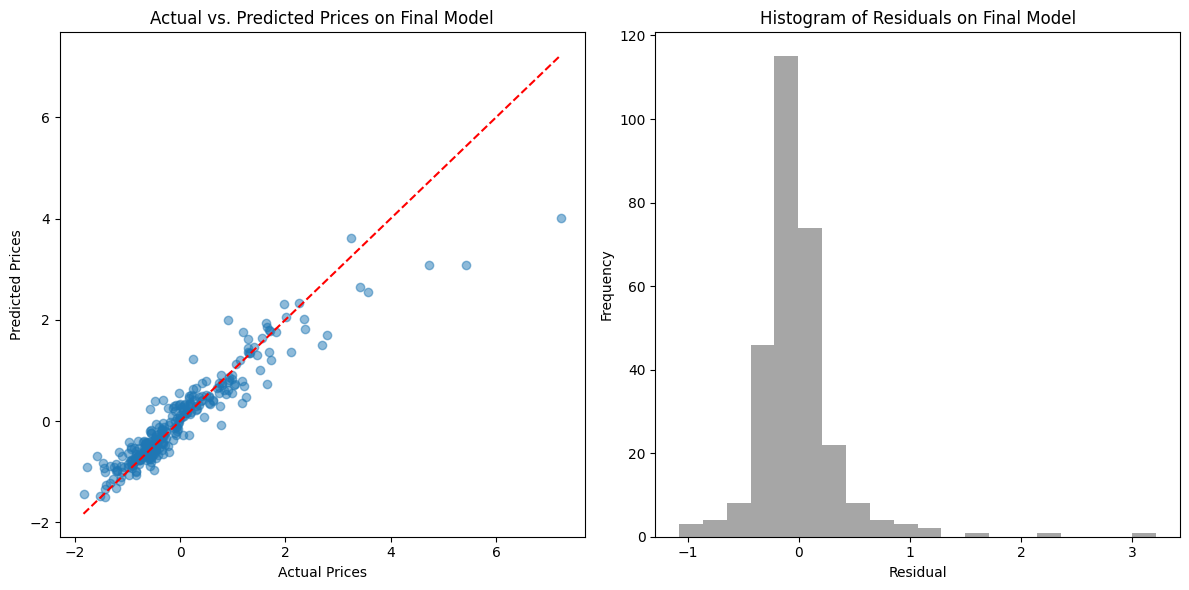

In [165]:
plt.figure(figsize=(12, 6))

# Scatter plot for actual vs predicted prices
plt.subplot(1, 2, 1)
plt.scatter(actual_prices, predicted_prices, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices on Final Model')
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], 'r--')  # Ideal line

# Histogram of the residuals
plt.subplot(1, 2, 2)
residuals = np.array(actual_prices) - np.array(predicted_prices)
plt.hist(residuals, bins=20, color='gray', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals on Final Model')

plt.tight_layout()
plt.show()


### 8.5. Optuna Model (Final Model) - Classifcation Road Heatmap

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

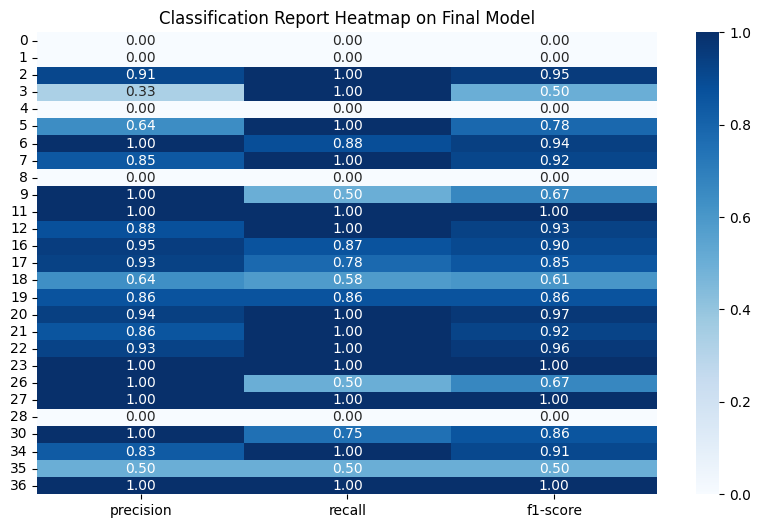

In [166]:


# Parse the classification report into a DataFrame
report = classification_report(actual_categories, predicted_categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Heatmap of the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-3, :-1], annot=True, cmap='Blues', fmt=".2f")  # Exclude 'accuracy' and support
plt.title('Classification Report Heatmap on Final Model')
plt.show()
